# ECE 445 (ML for ENGG): Term Project

By Akshitha Ajayan, Eric Jiang, Safa Shaikh

# Original Dataset: Air Quality in Madrid in 2018

The .csv file shows the air quality parameters (chemicals) measured at each of the stations in Madrid every 24 hours over the course of 4 months (January to April) in 2018. 

We originally planned to use regression on this dataset; however, we found that it was too difficult. There was no one parameter that would address air quality and instead showed the measurements of various chemicals in the air. There was also insuffient data; where many of the stations were missing half the chemicals. The only consistent readings among the chemcials was NO, NO_2, and NO_x. We would have needed to choose one as our target and two as our data, we would not have suffient information for a regression. Also, the presence of certain chemicals does not neccessairly correlate with the presence of other chemicals, so it would not have been a good dataset to choose for a regression classifier.

In [2]:
import csv
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import pandas as pd

with open('madrid_2018.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))

# creating all data for station 28079004
data = np.array(data)
data = data[1:data.shape[0],0:data.shape[1]]
airq = []
date = []
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        if(data[i,-1]=='28079004'):
            if(j==0):
                date.append(data[i,j])
            elif(data[i,j]==''):
                airq.append('0')
            else:
                airq.append(data[i,j])
            
airq = np.array(airq)
date = np.array(date)
airq = np.reshape(airq, (2880,15))

airq = airq.astype(np.float)

pddata = pd.read_csv("madrid_2018.csv")
pddata.head()

,date,BEN,CH4,CO,EBE,NMHC,NO,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL,station
0,2018-03-01 01:00:00,NaN,NaN,0.3,NaN,NaN,1.0,29.0,31.0,NaN,NaN,NaN,2.0,NaN,NaN,28079004
1,2018-03-01 01:00:00,0.5,1.39,0.3,0.2,0.02,6.0,40.0,49.0,52.0,5.0,4.0,3.0,1.41,0.8,28079008
2,2018-03-01 01:00:00,0.4,NaN,NaN,0.2,NaN,4.0,41.0,47.0,NaN,NaN,NaN,NaN,NaN,1.1,28079011
3,2018-03-01 01:00:00,NaN,NaN,0.3,NaN,NaN,1.0,35.0,37.0,54.0,NaN,NaN,NaN,NaN,NaN,28079016
4,2018-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,1.0,27.0,29.0,49.0,NaN,NaN,3.0,NaN,NaN,28079017


# Forecasting Temperature

In [3]:
with open('weatherHistory.csv', newline='') as csvfile:
    predata = list(csv.reader(csvfile))

# processing the csv information into target and data for regression
predata = np.array(predata)
predata = predata[1:predata.shape[0],3:-1]
np.random.shuffle(predata)
target = predata[:,0].astype(float)
data = predata[:,1:6].astype(float)

pddata = pd.read_csv("weatherHistory.csv")
pddata.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


We used the temperature (C) column as our target value and used apparent temperature (C), humidity, wind speed (km/h), wind bearing (degrees), and visibility (km) columns as our data parameters.

## Approach 1: Least Squares (using K-fold validation)

For the least sqaures approach, we used the algorithm and implementation discussed in class. The aim of regression is to be able to find a function such that $$y = Xw$$. In least squares, we use the following equation to find $\hat{w}$ which is $$\hat{w} = (X^TX)^{-1}y$$ on our training set. We can then use $$y = X\hat{w}$$ to find the predicted values for our test set.

0.9022477175204853
0.9146061521198523
0.8802204920553293
0.9061571188633867
0.9035167272508949
The average prediction error from 5-fold CV:  0.9013496415619897


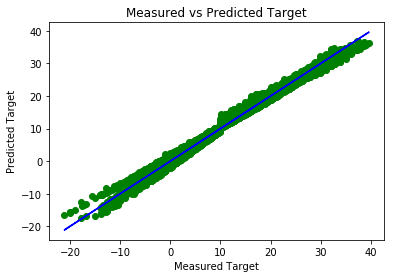

In [5]:
# function to calculate Least Sqaures on training set
def LS(data, labels):
    w_hat = np.matmul(np.matmul(LA.inv(np.matmul(np.transpose(data), data)), np.transpose(data)), labels)
    return w_hat

# function to check errors on test set
def LS_error(X, labels, w_hat):
    y_est = np.matmul(X, w_hat)
    error = LA.norm(labels-y_est)**2/X.shape[0]
    return y_est, error

# append ones column to our X
X = np.ones((len(data), 6))
for i in range(0, len(data)):
    for j in range(5):
        X[i, j] = data[i, j]

# split our data into test and validation for K fold CV, where K=5
test1 = X[0:19290]
testlab1 = target[0:19290]
train1 = X[19290:96453] 
label1 = target[19290:96453]

test2 = X[19290:38580, :]
testlab2 = target[19290:38580]
train2 = np.concatenate((X[0:19290, :], X[38580:96453, :]))
label2 = np.concatenate((target[0:19290], target[38580:96453]))

test3 = X[38580:57870, :]
testlab3 = target[38580:57870]
train3 = np.concatenate((X[0:38580, :], X[57870:96453, :]))
label3 = np.concatenate((target[0:38580], target[57870:96453]))

test4 = X[57870:77160, :]
testlab4 = target[57870:77160]
train4 = np.concatenate((X[0:57870, :], X[77160:96453, :]))
label4 = np.concatenate((target[0:57870], target[77160:96453]))

test5 = X[77160:96453, :]
testlab5 = target[77160:96453]
train5 = X[0:77160, :]
label5 = target[0:77160]

# train on each set and check error
w1 = LS(train1, label1)
y1, err1 = LS_error(test1, testlab1, w1)
print(err1)

w2 = LS(train2, label2)
y2, err2 = LS_error(test2, testlab2, w2)
print(err2)

w3 = LS(train3, label3)
y3, err3 = LS_error(test3, testlab3, w3)
print(err3)

w4 = LS(train4, label4)
y4, err4 = LS_error(test4, testlab4, w4)
print(err4)

w5 = LS(train5, label5)
y5, err5 = LS_error(test5, testlab5, w5)
print(err5)

# average prediction error for LS
avg = (err1+err2+err3+err4+err5)/5
print("The average prediction error from 5-fold CV: ", avg)

# plot of one of the measured vs predicted target values
plt.scatter(testlab4, y4, c='g')
plt.plot(testlab4,testlab4, 'b')
plt.title("Measured vs Predicted Target")
plt.xlabel("Measured Target")
plt.ylabel("Predicted Target")
plt.show()

## Approach 2: Ridge Regression (with K-fold CV)

For the ridge regression approach, we used the algorithm and implementation discussed in class. The aim of regression is to be able to find a function such that $$y = Xw$$. In lridge regression, we use the following equation to find $\hat{w}$ which is $$\hat{w} = (X^TX+\lambda I)^{-1}X^Ty$$ on our training set. We use K fold CV to find the optimal $\lambda$. We can then use $$y = X\hat{w}$$ to find the predicted values for our test set.

The average prediction error from 5-fold CV:  0.9013496409204915
From index:  1
Thus, the best lambda value: 0.1111111111111111


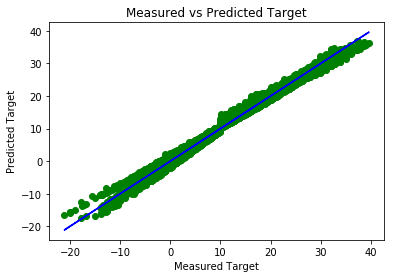

In [6]:
# function to calculate ridge regression on training data
def RR(data, labels, lam):
    w_hat = np.matmul(np.matmul(LA.inv(np.matmul(np.transpose(data), data)+lam*np.identity(data.shape[1])), np.transpose(data)), labels)
    return w_hat

# function to calulcate errors on test data
def RR_error(X, labels, w_hat):
    y_est = np.matmul(X, w_hat)
    error = LA.norm(labels-y_est)**2/X.shape[0]
    return y_est, error

# setting up lambda and errors for the K fold CV
lam = np.linspace(0, 10, num=91)
err1 = np.zeros(91)
err2 = np.zeros(91)
err3 = np.zeros(91)
err4 = np.zeros(91)
err5 = np.zeros(91)
avg = np.zeros(91)

# running K fold CV (where K=5) to find optimal lambda and check average prediction error
for i in range(0, len(lam)):
    w1 = RR(train1, label1, lam[i])
    y1, err1[i] = RR_error(test1, testlab1, w1)

    w2 = RR(train2, label2, lam[i])
    y2, err2[i] = RR_error(test2, testlab2, w2)

    w3 = RR(train3, label3, lam[i])
    y3, err3[i] = RR_error(test3, testlab3, w3)

    w4 = RR(train4, label4, lam[i])
    y4, err4[i] = RR_error(test4, testlab4, w4)

    w5 = RR(train5, label5, lam[i])
    y5, err5[i] = RR_error(test5, testlab5, w5)
    
    avg[i] = (err1[i]+err2[i]+err3[i]+err4[i]+err5[i])/5

# find optimal lambda and report average prediction error
print("The average prediction error from 5-fold CV: ", np.min(avg))
print("From index: ", np.argmin(avg))    
print("Thus, the best lambda value:", lam[np.argmin(avg)])

# plot optimal lambda and prediction for one of the test sets
w = RR(train4, label4, lam[np.argmin(avg)])
y, err = RR_error(test4, testlab4, w)
plt.scatter(testlab4, y, c='g')
plt.plot(testlab4,testlab4, 'b')
plt.title("Measured vs Predicted Target")
plt.xlabel("Measured Target")
plt.ylabel("Predicted Target")
plt.show()

# Regression Trees

Split data into train and test set.

In [7]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data,target,test_size = 0.3, random_state = 0)


In [8]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=7)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [9]:
# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
error1 = LA.norm(y_test-y_1)**2/y_test.shape[0]
error2 = LA.norm(y_test-y_2)**2/y_test.shape[0]
error3 = LA.norm(y_test-y_3)**2/y_test.shape[0]
print("Model 1 error is: ", error1)
print("Model 2 error is: ", error2)
print("Model 3 error is: ", error3)

Model 1 error is:  9.204779161993825
Model 2 error is:  0.7197620679873397
Model 3 error is:  0.174921031029276


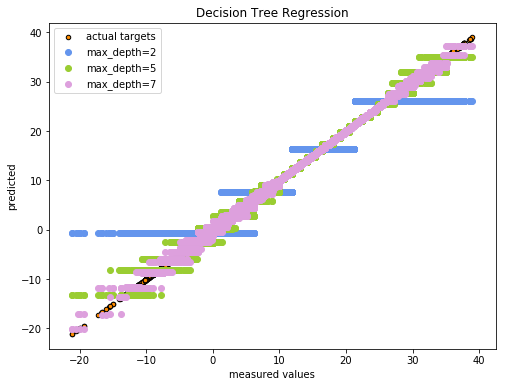

In [10]:
# Plot the results
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test, s=20, edgecolor="black", c="darkorange", label="actual targets")
plt.scatter(y_test, y_1, color="cornflowerblue",label="max_depth=2")
plt.scatter(y_test, y_2, color="yellowgreen", label="max_depth=5")
plt.scatter(y_test, y_3, color="plum",label="max_depth=7")
#plt.plot(y_test,y_test,c='g',label='actual')
plt.xlabel("measured values")
plt.ylabel("predicted")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

#### K-Fold CV with Regression Trees

In [51]:
def RegTree(X_train,X_test,y_train,y_test,max_depth=7):
    REG = DecisionTreeRegressor(max_depth=max_depth)
    REG.fit(X_train,y_train)
    y_pred = REG.predict(X_test)
    error = LA.norm(y_test-y_pred)**2/y_test.shape[0]
    #print("error is: ", error)
    return error

In [52]:
from sklearn.model_selection import KFold
X = data
y = target
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
print(kf)
X_tr_l = []
X_test_l = []
y_tr_l = []
y_test_l = []
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_tr_l.append(X_train)
    X_test_l.append(X_test)
    y_tr_l.append(y_train)
    y_test_l.append(y_test)

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [    0     2     3 ... 96446 96449 96451] TEST: [    1     9    14 ... 96448 96450 96452]
TRAIN: [    0     1     3 ... 96450 96451 96452] TEST: [    2     5     7 ... 96430 96433 96441]
TRAIN: [    0     1     2 ... 96450 96451 96452] TEST: [    6     8    12 ... 96432 96434 96438]
TRAIN: [    1     2     3 ... 96449 96450 96452] TEST: [    0     4    18 ... 96428 96437 96451]
TRAIN: [    0     1     2 ... 96450 96451 96452] TEST: [    3    11    20 ... 96442 96446 96449]


In [53]:
depths = [2,5,7,11,15,19]
davgerr = []
foldidx = []
for d in depths:
    errors = []
    for i in range(len(X_tr_l)):
        errors.append(RegTree(X_tr_l[i],X_test_l[i],y_tr_l[i],y_test_l[i],d))
    idx = np.argmin(errors)
    foldidx.append(idx)
    avgerror = np.mean(errors)
    print("Average error for depth ",d," is: ",avgerror)
    davgerr.append(avgerror)
didx = np.argmin(davgerr)
X_train = X_tr_l[foldidx[didx]]
X_test = X_test_l[foldidx[didx]]
y_train = y_tr_l[foldidx[didx]]
y_test= y_test_l[foldidx[didx]]
best_depth = depths[didx]
print("Best depth is: ",best_depth)
print("Average error is: ",avgerror)

Average error for depth  2  is:  9.272236413151003
Average error for depth  5  is:  0.7326429044805193
Average error for depth  7  is:  0.17453091013390082
Average error for depth  11  is:  0.014278740345745052
Average error for depth  15  is:  0.0059971667637688355
Average error for depth  19  is:  0.005496181169300671
Best depth is:  19
Average error is:  0.005496181169300671


In [58]:
REG = DecisionTreeRegressor(max_depth=best_depth)
REG.fit(X_train,y_train)
y_pred = REG.predict(data)
error = LA.norm(target-y_pred)**2/y_test.shape[0]
print("Error of Regression Tree is: ",error)

Error of Regression Tree is:  0.004561078915428029


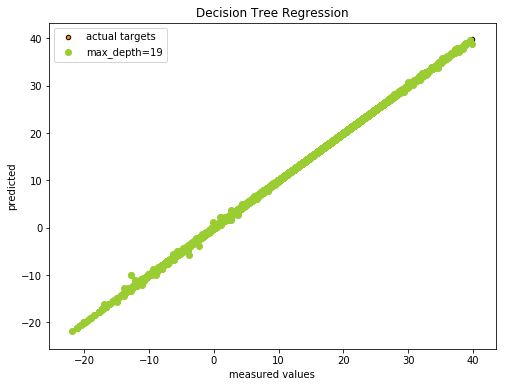

In [59]:
# Plot the results
plt.figure(figsize=(8,6))
plt.scatter(target, target, s=20, edgecolor="black", c="darkorange", label="actual targets")
plt.scatter(target, y_pred, color="yellowgreen", label="max_depth={}".format(best_depth))
plt.xlabel("measured values")
plt.ylabel("predicted")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Fruits Dataset

This dataset contains images of various fruits. Our objective is to be able to build a classifier that can recognize a fruit, given its image. For this exercise, we have chosen 3 fruits: Banana, Limes, and Pineapple. We will employ 3 methods of classification: Support Vector Machines (SVM), Logistic Regression, and Classification Trees

### _Extract Data_

In [1]:
import os
import numpy as np
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

Extract images from Training folder and convert and resize each image to a $45\times45\times3$ sized numpy array. Record the labels for each image.

In [2]:
fruits = []
labels = [] 
fruits_f = []
for fruit_dir in glob.glob("fruits/Training/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        fruits.append(img)
        fruits_f.append(imgf)
        labels.append(fruit_label)
fruits = np.array(fruits)
labels = np.array(labels)
fruits_f = np.array(fruits_f)
print(fruits.shape,labels.shape)
print(labels)

(1470, 45, 45, 3) (1470,)
['Banana' 'Banana' 'Banana' ... 'Pineapple' 'Pineapple' 'Pineapple']


Our labels are string values and we need to assign numeric IDs to every class. Here, $Banana = 0$, $Limes = 1$, and $Pineapple = 2$.

In [3]:
id_to_labels = {i:v for i,v in enumerate(np.unique(labels))}
print(id_to_labels)
label_to_ids = {v:i for i,v in id_to_labels.items()}
label_ids = np.array([label_to_ids[x] for x in labels])
label_names = [v for i,v in id_to_labels.items()]
print(label_ids)

{0: 'Banana', 1: 'Limes', 2: 'Pineapple'}
[0 0 0 ... 2 2 2]


Flatten each image and mean-center so we can easily manipulate the data for PCA and future processing.

In [4]:
import numpy.linalg as la
images = np.array([i.flatten() for i in fruits])
print(images.shape)
m = np.mean(images)
im_bar = images - m

(1470, 6075)


Text(0,0.5,'Y (log scale)')

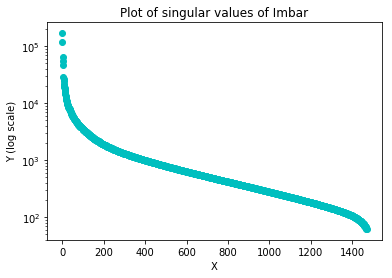

In [5]:
im_bar = im_bar.transpose() # so data is in M x N form
%matplotlib inline
import matplotlib.pyplot as plt
U,s,VT = la.svd(im_bar)
fig = plt.figure()
x = np.arange(s.shape[0])
y = s
ax = fig.add_subplot(111)
plt.yscale('log')
ax.scatter(x, y, c='c', marker='o')
ax.set_title("Plot of singular values of Imbar")
ax.set_xlabel('X')
ax.set_ylabel('Y (log scale)')

Find the top k components that encompass most of the data.

In [6]:
#im_bar = im_bar.transpose()
#finding smallest k to encompass 90% of data
s_sum = 0
fnorm = la.norm(im_bar)**2

k = 0
for i in range(s.shape[0]):
    s_sum = s_sum + s[i]**2
    t = s_sum/fnorm
    if(t >= 0.964):
        k = i
        break
#top k principal components of Xbar

print("k is: ",k)

k is:  51


Compute features and reconstruct data from principal components. Display a random image from the reconstructed data to check if the data construction matches the overall structure of a fruit.

(51, 1470)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6075, 1470)


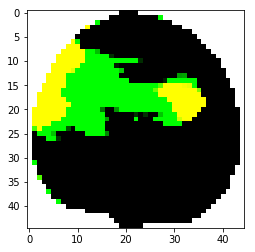

In [7]:
Uk = U[:,0:k]
features = Uk.transpose()@im_bar
print(features.shape)
recon = Uk@Uk.transpose()@im_bar
print(recon.shape)
r = np.random.randint(0,im_bar.shape[1])
img = np.reshape(recon[:,r],(45,45,3))
plt.imshow(img)

### Sklearn PCA

Sklearn also has it's own pca function. We use it for consistency with sklearn's methods.

In [8]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform([i.flatten() for i in fruits])
print(images_scaled.shape)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

(1470, 6075)


In [9]:
print(pca_result.shape) # confirm (1470 x 50)

(1470, 50)


In order to plot the result of the PCA, we need to be able to view a 50-dimensional data point in 2 dimensions. TSNE is function in sklearn (called t-distributed Stochastic Neighbor Embedding) that allows you to reduce dimensionality. Making the data 2D will allow us to see if all classes are relatively disjoint (SVM likely to succeed) or if the classes overlap (SVM likely to have errors).

(1470, 2)


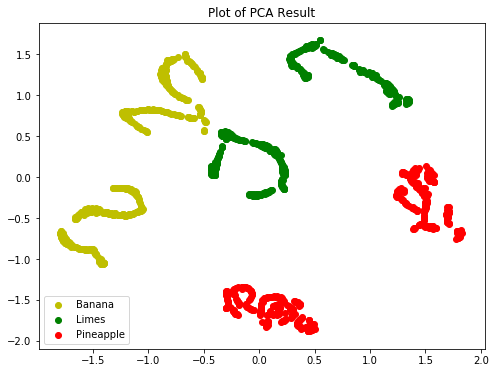

In [10]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

## Split into Training and Test Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

### Train Model using SVM

Linear SVM uses the form $f(x) = w^Tx+b$ to form a hyperplane that can split two classes. Kernel SVM maps a lower dimensional space to a higher dimension and finds an appropriate function, that can be non-linear, in order to divide two classes. Sklearn's SVM function uses kernel SVM to find multiple hyperplanes to divide more than two classes.

In [12]:
svm_clf = svm.SVC()
svm_clf = svm_clf.fit(X_train, y_train) 

In [13]:
test_predictions = svm_clf.predict(X_test)

In [14]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Training Accuracy with SVM: {0:.6f}".format(precision))

Training Accuracy with SVM: 94.293478


In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(test_predictions, y_test,target_names=label_names))
print(confusion_matrix(test_predictions, y_test, labels=range(3)))

             precision    recall  f1-score   support

     Banana       0.83      1.00      0.91       103
      Limes       1.00      1.00      1.00       117
  Pineapple       1.00      0.86      0.92       148

avg / total       0.95      0.94      0.94       368

[[103   0   0]
 [  0 117   0]
 [ 21   0 127]]


### Test SVM Model on Validation Data

In [16]:
val_fruits = []
val_labels = [] 
val_fruits_f = []
for fruit_dir in glob.glob("fruits/Test/*"):
    fruit_dir = fruit_dir.replace('\\', '/')
    fruit_label = fruit_dir.split("/")[-1]
    for img in glob.glob(os.path.join(fruit_dir, "*.jpg")):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (45, 45))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        imgf = np.reshape(img,(45*45,3))
        val_fruits.append(img)
        val_fruits_f.append(imgf)
        val_labels.append(fruit_label)
val_fruits = np.array(val_fruits)
val_labels = np.array(val_labels)
val_fruits_f = np.array(val_fruits_f)
print(val_fruits.shape,val_labels.shape)

(498, 45, 45, 3) (498,)


In [17]:
val_label_ids = np.array([label_to_ids[i] for i in val_labels])
val_images_scaled = scaler.transform([i.flatten() for i in val_fruits])
val_pca_res = pca.transform(val_images_scaled)
print(val_pca_res.shape)

(498, 50)


(498, 2)


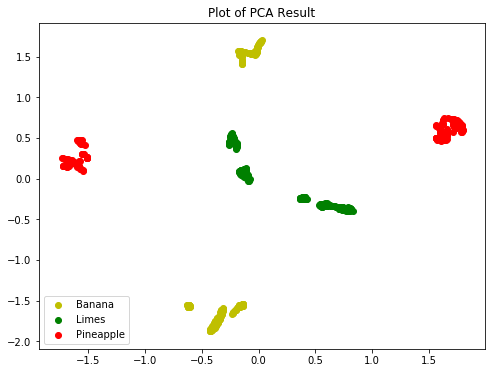

In [18]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(val_pca_res)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print(tsne_result_scaled.shape)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)

for i in range(tsne_result_scaled.shape[0]):
    if (val_label_ids[i]==0):
        zerop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='y', marker='o')
    if (val_label_ids[i]==1):
        onep = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='g', marker='o')
    if (val_label_ids[i]==2):
        twop = ax.scatter(tsne_result_scaled[i][0], tsne_result_scaled[i][1], c='r', marker='o')
ax.set_title("Plot of PCA Result")
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([zerop,onep,twop], ["Banana","Limes","Pineapple"],loc=3)
plt.show()

In [19]:
test_predictions = svm_clf.predict(val_pca_res)

In [20]:
precision = accuracy_score(test_predictions, val_label_ids) * 100
print("Validation Accuracy with SVM: {0:.6f}".format(precision))

Validation Accuracy with SVM: 64.056225


# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

## Binary Logistic Regression

In [23]:
import itertools
B= '\033[1m'
E= '\033[0m'

## Define function to plot matrix based on:
## [[True Non, False Fraud],[False Non, True Fraud]]

def plot_confusion_matrix(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(len([0,1]))
    plt.xticks(tick_marks, ["Banana {0}","Lime {1}"], rotation=0)
    plt.yticks(tick_marks, ["Banana {0}","Lime {1}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")
    
def plot_confusion_matrix2(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ["Banana {0}","Lime {1}", "Pineapple {2}"], rotation=0)
    plt.yticks(tick_marks, ["Banana {0}","Lime {1}", "Pineapple {2}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    #print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    #print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")

Accuracy with LogisticRegressionCV: 100.000000


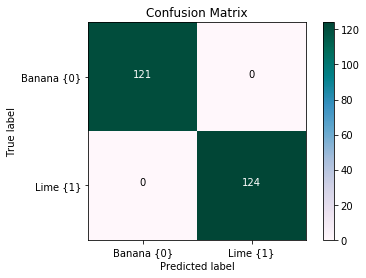

Matrix Recall: 100.0 %
Matrix Precision: 100.0 %


In [151]:
two_classes = []
two_classes_id = []
for i in range(0, label_ids.shape[0]):
    if(label_ids[i]!=2):
        two_classes.append(pca_result[i,:])
        two_classes_id.append(label_ids[i])
two_classes_id = np.array(two_classes_id)
two_classes = np.array(two_classes)

X_train, X_test, y_train, y_test = train_test_split(two_classes, two_classes_id, test_size=0.25, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)

precision = accuracy_score(predictions, y_test) * 100
print("Accuracy with LogisticRegressionCV: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix)

## Multi-class Logisitic Regression

Accuracy with LogisticRegressionCV: 100.000000


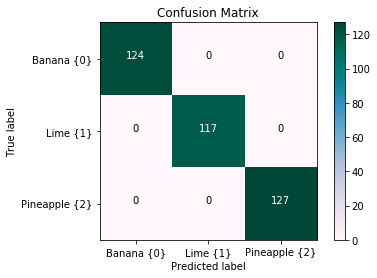

             precision    recall  f1-score   support

     Banana       1.00      1.00      1.00       124
      Limes       1.00      1.00      1.00       117
  Pineapple       1.00      1.00      1.00       127

avg / total       1.00      1.00      1.00       368



In [152]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X_train, y_train)
predictions = clf.predict(X_test)

precision = accuracy_score(predictions, y_test) * 100
print("Accuracy with LogisticRegressionCV: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)
print(classification_report(predictions, y_test,target_names=label_names))

# Classification Trees

We use Sklearn's DecisionTreeClassifier, which defaults to using the gini index as a metric for measuring variance. 
Initially we will randomly choose a training and test split.

In [21]:
from sklearn.tree import DecisionTreeClassifier
import numpy.linalg as LA
DT = DecisionTreeClassifier(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

Fit the model to training data.

Accuracy with Classification Trees: 99.456522


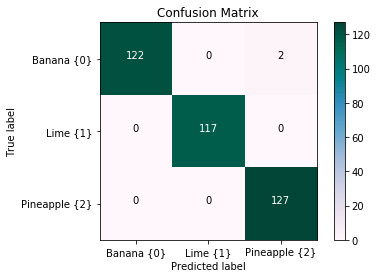

             precision    recall  f1-score   support

     Banana       0.98      1.00      0.99       122
      Limes       1.00      1.00      1.00       117
  Pineapple       1.00      0.98      0.99       129

avg / total       0.99      0.99      0.99       368



In [24]:
DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with Classification Trees: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)

print(classification_report(y_pred, y_test,target_names=label_names))

Notice we have a 99.46% accuracy on this random test/train split. Let's find the optimal split using K-fold Cross Validation. Create a function for a Decision Tree Classifier.

In [38]:
def DTClassifier(X_train,X_test,y_train,y_test):
    DT = DecisionTreeClassifier(random_state=0)
    DT.fit(X_train,y_train)
    y_pred = DT.predict(X_test)
    precision = accuracy_score(y_pred, y_test) * 100
    print("Accuracy with Classification Trees: {0:.6f}".format(precision))
    return precision

In [39]:
from sklearn.model_selection import KFold
X = pca_result
y = label_ids
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
print(kf)
X_tr_l = []
X_test_l = []
y_tr_l = []
y_test_l = []
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_tr_l.append(X_train)
    X_test_l.append(X_test)
    y_tr_l.append(y_train)
    y_test_l.append(y_test)

KFold(n_splits=5, random_state=None, shuffle=True)


After creating our 3 sets of 3-fold test/train data, we can run fit our classifier to each of the 3 training sets and see which training set performs with the highest accuracy and save the set.

In [40]:
accuracy = []
for i in range(len(X_tr_l)):
    accuracy.append(DTClassifier(X_tr_l[i],X_test_l[i],y_tr_l[i],y_test_l[i]))
    #print("running")
idx = np.argmax(accuracy)
#X_train = X_tr_l[idx]
#X_test = X_test_l[idx]
#y_train = y_tr_l[idx]
#y_test= y_test_l[idx]
#print(X_train.shape,X_test.shape)
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)
#print("Best fold is: ",idx+1)
print("Average Accuracy with Classification Trees is: ",np.mean(accuracy))

Accuracy with Classification Trees: 99.659864
Accuracy with Classification Trees: 99.319728
Accuracy with Classification Trees: 99.659864
Accuracy with Classification Trees: 100.000000
Accuracy with Classification Trees: 99.659864
Average Accuracy with Classification Trees is:  99.65986394557824


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Accuracy with Classification Tree: 99.863946


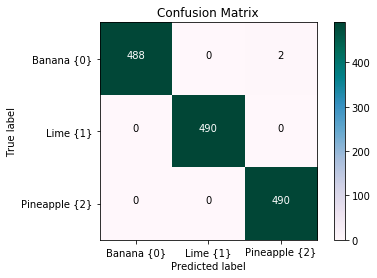

             precision    recall  f1-score   support

     Banana       1.00      1.00      1.00       488
      Limes       1.00      1.00      1.00       490
  Pineapple       1.00      1.00      1.00       492

avg / total       1.00      1.00      1.00      1470



In [41]:
DT = DecisionTreeClassifier(random_state=0)
print(DT)
DT.fit(X_train,y_train)
y_pred = DT.predict(pca_result)
precision = accuracy_score(y_pred, label_ids) * 100
print("Accuracy with Classification Tree: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(label_ids,y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)
print(classification_report(y_pred, label_ids,target_names=label_names))

Now that we have trained our data, we can test it on a validation set and see how our classifier performs. 

Validation Accuracy with Classification Trees: 99.196787


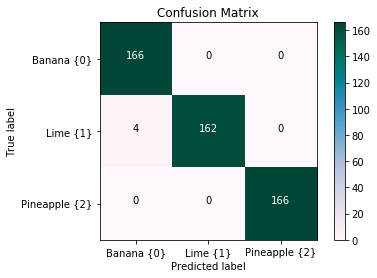

             precision    recall  f1-score   support

     Banana       1.00      0.98      0.99       170
      Limes       0.98      1.00      0.99       162
  Pineapple       1.00      1.00      1.00       166

avg / total       0.99      0.99      0.99       498



In [173]:
val_pred = DT.predict(val_pca_res)
precision = accuracy_score(val_pred, val_label_ids) * 100
print("Validation Accuracy with Classification Trees: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_label_ids,val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)
print(classification_report(val_pred, val_label_ids,target_names=label_names))

### Random Forest 

Random Forest is a type of classification tree technique that uses bootstrapping. Let's see if this method will work better or worse than general classification trees:

Accuracy with RandomForest: 100.000000


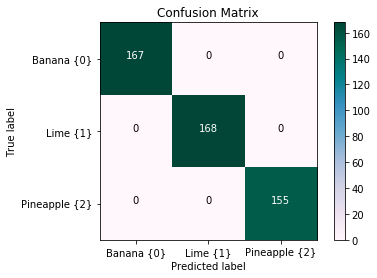

             precision    recall  f1-score   support

     Banana       1.00      1.00      1.00       167
      Limes       1.00      1.00      1.00       168
  Pineapple       1.00      1.00      1.00       155

avg / total       1.00      1.00      1.00       490



In [174]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)
test_predictions = forest.predict(X_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,test_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)
print(classification_report(test_predictions, y_test,target_names=label_names))

Validation Accuracy with Random Forest: 100.000000


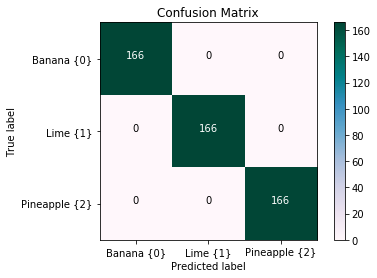

             precision    recall  f1-score   support

     Banana       1.00      1.00      1.00       167
      Limes       1.00      1.00      1.00       168
  Pineapple       1.00      1.00      1.00       155

avg / total       1.00      1.00      1.00       490



In [175]:
val_predictions = forest.predict(val_pca_res)
precision = accuracy_score(val_predictions, val_label_ids) * 100
print("Validation Accuracy with Random Forest: {0:.6f}".format(precision))

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_label_ids,val_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix2(cnf_matrix)
print(classification_report(test_predictions, y_test,target_names=label_names))

In this case, random forest seems to be the optimal classifier since it operates at 100% accuracy, just like logistic regression.

# ECE 445 (ML for ENGG): Credit Card Fraud Detection

*Eric Jiang ewj12 158002948*

12/14/2018

**This dataset contains transactions from European credit cards in September 2013.**

The variables are unknown due to confidentiality issues.

*The only known variables are:*

**Time** - Time it takes to reach final transaction

**Amount** - Amount in the transaction

**Class** - Determines if fraud (1) or non-fraud (0)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

B= '\033[1m'
E= '\033[0m'

In [7]:
#Import the CSV and display the header
dfo = pd.read_csv("creditcard.csv")
dfo.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


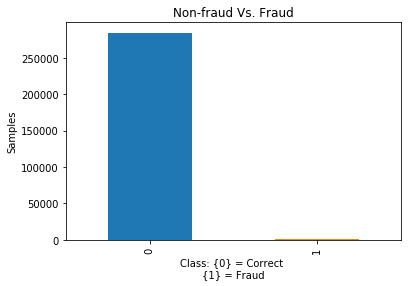

Number of Correct Samples: 284315
Number of Fraud Samples: 492
Ratio of Fraud to Correct: 0.0017304750013189597


In [8]:
#Portray the frequency of fraud
count_classes = pd.value_counts(dfo['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Non-fraud Vs. Fraud")
plt.xlabel("Class: {0} = Correct \n{1} = Fraud")
plt.ylabel("Samples")
plt.show()

correct = count_classes.tolist()[0]
fraud = count_classes.tolist()[1]
print(B+"Number of Correct Samples:"+E, correct)
print(B+"Number of Fraud Samples:"+E, fraud)
print(B+"Ratio of Fraud to Correct:"+E, fraud/correct)

**Since the # of fraud samples is only 0.17% of the dataset, the data needs to be undersampled for processing classifiers.** 

**Undersample the data (with 50% fraud and 50% non-fraud) to manipulate for PCA and graphing purposes**

*Creating a sub-sample will solve overfitting -* With most samples as non-fraud, the classifiers will assume that almost all cases are non-frauds leading to poor precision.

In [9]:
from sklearn.preprocessing import StandardScaler

# StandardScalar().fit_transform(X, y=None)
# fits data (computes mean and std) and transforms (by centering/scaling)
# X = training set with y as target value (typically none)

## STANDARDIZE THE DATA (TIME & AMOUNT) ##
dfo['normAmount'] = StandardScaler().fit_transform(dfo['Amount'].values.reshape(-1, 1))
df = dfo.drop(['Time','Amount'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


New undersampled sub-sample
Fraudulent samples: 492
Non-fraud samples: 492


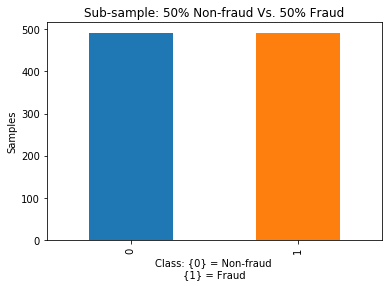

In [10]:
#Data
X = df.loc[:, df.columns != 'Class']

#Labels
Y = df.loc[:, df.columns == 'Class']

# Number of Fraud Records
frecs = len(df[df.Class == 1])

# Corresponding fraud indices in CSV
fi = np.array(df[df.Class == 1].index)

# Non-fruad indices in CSV
ni = df[df.Class == 0].index

# Create Array of random non-fraud indices with same size as fraud indices
ri = np.array(np.random.choice(ni, frecs, replace = False))

# Append the fraud indices with random non-fraud indices (50% fraud 50% non-fraud)
usd = np.concatenate([fi,ri])

# Under sampled dataset
usd = df.iloc[usd,:]

print(B+"New undersampled sub-sample"+E)
print(B+"Fraudulent samples:"+E, len(fi))
print(B+"Non-fraud samples:"+E, len(ri))

count_classes = pd.value_counts(usd['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Sub-sample: 50% Non-fraud Vs. 50% Fraud")
plt.xlabel("Class: {0} = Non-fraud \n{1} = Fraud")
plt.ylabel("Samples")
plt.show()

**Scramble the sub-sample and divide the data/class labels for training**

In [11]:
# Scramble the dataset so fraud isn't ordered first
usd = usd.sample(frac=1)

# Undersampled X data and Y labels via Class
Xu = usd.loc[:, usd.columns != 'Class'] 
Yu = usd.loc[:, usd.columns == 'Class'] # Yu == 1 then fraud otherwise 0

# Approach 1) K-Nearest Neighbor Classifier

**First obtain 2-D PCA of Data**

Create Training and Test sets for k-NN

In [12]:
#Optimize the train/test lengths (this uses 15% of data as test)
test_percent = .15
test_len = (np.floor(test_percent*len(Xu))).astype(int)
train_len = (len(Xu)-test_len).astype(int)

#Create Training Data
training_data = Xu[:train_len]
training_labels = Yu[:train_len]

#Create Test Data
test_data = Xu[train_len:]
test_labels = Yu[train_len:]

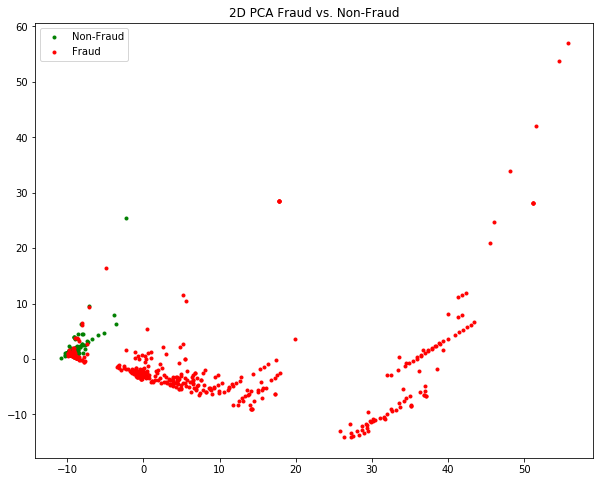

In [13]:
# Transpose the data matrix so each sample is a column
X = training_data.T

mean_vec = (np.sum(X, axis=1))/(X.shape[1])
mean_mat = np.tile(mean_vec.values.reshape(X.shape[0],1),[1,X.shape[1]])

#center the matrix
centered_X = X - mean_mat

#Singular Value Decomp centered matrix
U, s, Vh = np.linalg.svd(centered_X)

#Top 2 principal components of the centered data matrix
U2 = U[:,0:2]

#PCA features
X_tilde = U2.T@centered_X

#reconstruction
X_hat = U2@X_tilde + mean_mat

# Scatter plot for Fraud Vs. Non-Fraud
plt.figure(figsize=(10,8))
plt.scatter(X_tilde.T[np.where(training_labels==0),0],X_tilde.T[np.where(training_labels==0),1],c='g',marker='.',label='Non-Fraud')
plt.scatter(X_tilde.T[np.where(training_labels==1),0],X_tilde.T[np.where(training_labels==1),1],c='r',marker='.',label='Fraud')
plt.title('2D PCA Fraud vs. Non-Fraud')
plt.legend()
plt.show()

**From this 2D PCA plot, it seems that half of fraud can be seperated. However, a good portion is still within the same region as Non-fraud**

In [14]:
##### Find the 2D PCA features of test_data set #####

# Transpose the data matrix so each sample is a column
X = test_data.T

mean_vec = (np.sum(X, axis=1))/(X.shape[1])
mean_mat = np.tile(mean_vec.values.reshape(X.shape[0],1),[1,X.shape[1]])

#center the matrix
centered_X = X - mean_mat

#Singular Value Decomp centered matrix
U, s, Vh = np.linalg.svd(centered_X)

#Top 2 principal components of the centered data matrix
U2 = U[:,0:2]

#X_tilde1 = 2D PCA features of test_set
X_tilde1 = U2.T@centered_X

**Creating k-NN algorithm**

In [15]:
#Create class imagelabel(image = norm, label = 0,1)
#Use for knn to sort data as images based on norm while keeping its label
class imagelabel:
    def __init__(self, image, label):
        self.image = image
        self.label = label
    def __repr__(self):
        return repr((self.image, self.label))

#Create k-NN function to calculate the norms to the desired 'point'
#Using closest 'k' # of points to classify labels
def knn(point,k):
    #Create a matrix to store all the norm distances w/ labels
    norm_mat = []
    
    #Use the train_len pt of the training_data set
    for i in range (0,train_len):
        #Use X_tilde the 2D PCA features of training_data
        #Find norm between point and training set
        norm = np.linalg.norm(point-X_tilde.T[i])
        
        #append each (norm, label) using class imagelabel(norm,label)
        if training_labels.values[i] == 0: 
            norm_mat.append(imagelabel(norm,0))
        else:
            norm_mat.append(imagelabel(norm,1))
    
    #sort based on image's closest norms
    nmsort = sorted(norm_mat, key=lambda pt: pt.image)
    
    #Create counters to determine labels for k closest pts.
    counter0 = 0
    counter1 = 0
    
    #loop through k closest points
    for i in range (0,k):
        nms = nmsort[i]
        if nms.label == 0: #if label = 0 counter0++
            counter0+=1
        else:
            counter1+=1 #else label = 1 counter1++
    
    #output 0,1 label corresponding to highest counter
    if counter0 >= counter1:
        output = 0
    else:
        output = 1
    
    #return norm matrix, sorted norm matrix in order of closest to furthest pts, 0-1 output
    return norm_mat, nmsort, output

**Plotting k-NN Data with k = 5**

In [16]:
#create right/wrong 2D pts for plotting
xtright = []
ytright = []
xtwrong = []
ytwrong = []

#Counter for true/false frauds and non-frauds
tf = 0
tn = 0
ff = 0
fn = 0

#loop through the test_len to compare k-NN output to label
for i in range (0, test_len):
    nm, nm2, o = knn(X_tilde1.T[i],5)
    xn = X_tilde1.T[i,0]
    yn = X_tilde1.T[i,1]
    
    #if output = test_label then k-NN classified right
    #else classified wrong
    if o == test_labels.values[i]:
        xtright.append(xn) #append right pts for plot
        ytright.append(yn)
        #print('index',i, o, 'right')
        #Increment True counters accordingly
        if o == 1:
            tf+=1
        else:
            tn+=1
            
    else:
        xtwrong.append(xn) #append wrong pts for plot
        ytwrong.append(yn)
        #print('index:',i, o, 'wrong')
        #Increment False counters accordingly
        if o == 1:
            ff+=1
        else:
            fn+=1


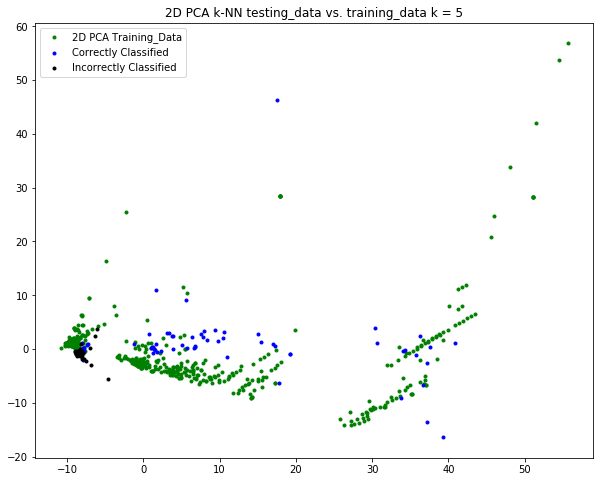

Error with k = 5: 0.5102040816326531


In [17]:
#Plotting on graph and displaying error

plt.figure(figsize=(10,8))
plt.scatter(X_tilde.T[:,0],X_tilde.T[:,1], color = 'green', marker = '.', label = '2D PCA Training_Data')
plt.scatter(xtright,ytright, color = 'blue', marker = '.', label = 'Correctly Classified')
plt.scatter(xtwrong,ytwrong, color = 'black', marker = '.', label = 'Incorrectly Classified')
plt.title('2D PCA k-NN testing_data vs. training_data k = 5')
plt.legend()
plt.show()

err = len(xtwrong)/test_len
print(B+'Error with k = 5:'+E, err)

## From 2-D PCA it is apparent that the outliers can be classified, but a decent amount of frauds are too close to non-frauds. This would lead to more false reports. 
## **To fix this issue, metrics from the binary matrix should be analyzed in depth.**

**The Recall metric would help determine the amount of false non-frauds (frauds that went undetected as innocent)**

**The Precision metric would help determine the amount of false frauds (innocent transactions that were mistakenly detected as fraud)**

*Recall* = True pos/(True pos + False neg)

*Recall* = True fraud/(True fraud + False non-fraud)

*Precision* = True pos/(True pos + False pos)

*Precision* = True fraud/(True fraud + False Fraud)

In [18]:
print(B+"True/False k-NN results"+E)
print("True Fraud =", tf)
print("True Non-fraud =", tn)
print("False Fraud =", ff)
print("False Non-fraud =", fn)

True/False k-NN results
True Fraud = 71
True Non-fraud = 1
False Fraud = 72
False Non-fraud = 3


**Define function to create and plot a binary confusion matrix**

In [19]:
import itertools

## Define function to plot matrix based on:
## [[True Non, False Fraud],[False Non, True Fraud]]

def plot_confusion_matrix(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(len([0,1]))
    plt.xticks(tick_marks, ["Non-Fraud {0}","Fraud {1}"], rotation=0)
    plt.yticks(tick_marks, ["Non-Fraud {0}","Fraud {1}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")

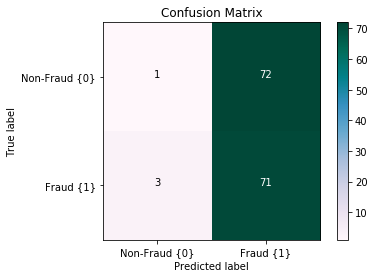

Matrix Recall: 95.94594594594594 %
Matrix Precision: 49.65034965034965 %


In [20]:
knncm = np.array([[tn,ff],[fn,tf]])
class_names = ["Non-Fraud {0}","Fraud {1}"]
plot_confusion_matrix(knncm)

Recall and precision affect each other inversely. Higher recall would lead to lower precision and vice versa.

Maximizing both is ideal, but Recall should be prioritized as it maximizes the detection of frauds (both real and fake). Whereas precision affects the rate of false alarms, an innocent result compared to the prior.

*Note: K-means centroid clustering may be a better solution to this problem due to the large variation of the given features.*

# Approach 2) Logistic Regression Classifier

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

### Kfold(n number of elements, n_folds, shuffle = 'False', random_state)
## Shuffle, true if want to scramble the data false otherwise
## random_state if different values produce different resulting sets
## if random_state is set to a constant value then reproduces same results
## returns folds

### recall_score(y_true,y_pred)
## y_true = correct labels
## y_pred = predicted labels via classifier
## Outputs recall score

### confusion_matrix(y_true, y_pred)
## In binary case returns array (tn, fp, fn, tp)

C:\Users\SAFAS\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Find optimal C parameter for Logistic Regression**

In [22]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),3,shuffle=False, random_state = 1) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('Parameter for C =', c_param)
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Test c_param for Logistic regression via L1 norm
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('________________________________________________')

    best_c = results_table
    best_c.dtypes.eq(object) # you can see the type of best_c
    new = best_c.columns[best_c.dtypes.eq(object)] #get the object column of the best_c
    best_c[new] = best_c[new].apply(pd.to_numeric, errors = 'coerce', axis=0) # change the type of object
    best_c
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter'] #calculate the mean values
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    
    print('Optimal C parameter = ', best_c)
    
    return best_c

best_c = printing_Kfold_scores(training_data,training_labels)

Parameter for C = 0.01

Iteration 1 : recall score =  0.9705882352941176
Iteration 2 : recall score =  0.9455782312925171
Iteration 3 : recall score =  0.9555555555555556

Mean recall score  0.9572406740473968
________________________________________________
Parameter for C = 0.1

Iteration 1 : recall score =  0.9264705882352942
Iteration 2 : recall score =  0.8979591836734694
Iteration 3 : recall score =  0.8814814814814815

Mean recall score  0.9019704177967484
________________________________________________
Parameter for C = 1

Iteration 1 : recall score =  0.9338235294117647
Iteration 2 : recall score =  0.8979591836734694
Iteration 3 : recall score =  0.8962962962962963

Mean recall score  0.9093596697938434
________________________________________________
Parameter for C = 10

Iteration 1 : recall score =  0.9411764705882353
Iteration 2 : recall score =  0.9047619047619048
Iteration 3 : recall score =  0.8962962962962963

Mean recall score  0.9140782238821455
___________________

**Use Optimal C parameter to create confusion matrix for analyzing**

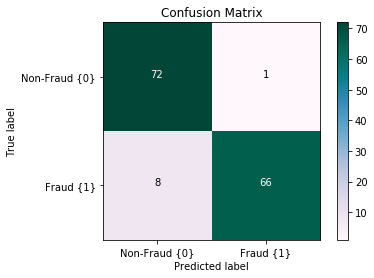

Matrix Recall: 89.1891891891892 %
Matrix Precision: 98.50746268656717 %


In [25]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(training_data,training_labels.values.ravel())
y_predu = lr.predict(test_data.values)

# Compute confusion matrix
cm_lr = confusion_matrix(test_labels,y_predu)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm_lr)

## Approach 3) Support Vector Machine Classifier

In [26]:
#Using the gaussian kernel to build the initail model. Let us see if this is the best parameter later
from sklearn.svm import SVC

classifier= SVC(C= 1, kernel= 'rbf', random_state= 0)
classifier.fit(training_data, training_labels.values.ravel())

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
#Predict the class using X_test
y_pred = classifier.predict(test_data)

#cm1 is the confusion matrix 1 which uses the undersampled dataset
cm1 = confusion_matrix(test_labels, y_pred)

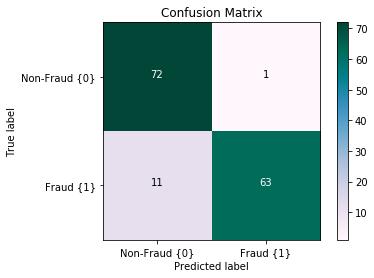

Matrix Recall: 85.13513513513513 %
Matrix Precision: 98.4375 %


In [29]:
plot_confusion_matrix(cm1)


In [30]:
from sklearn.model_selection import cross_val_score
## cross_val_score(estimator,X,y,cv,scoring)
# estimator -> classifier
# X = data | Y = labels | cv = folds | scoring = type of metric to estimate
# returns a set of scoring metrics unless specified via 'scoring param'

#Applying 10 fold cross validation
recall = cross_val_score(estimator = classifier, X=training_data, y = training_labels.values.ravel(), scoring = 'recall', cv = 10)
mean_recall= recall.mean()
std_recall= recall.std()
print("Mean Recall Score:", mean_recall, "%")
print("Model's recall range: {} to {}".format(mean_recall-std_recall, mean_recall+std_recall),"%")

Mean Recall Score: 0.918466898954704 %
Model's recall range: 0.8821979652295568 to 0.9547358326798512 %


In [31]:
from sklearn.model_selection import GridSearchCV

# Use GridSearchCV to estimate optimal parameter

parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'recall', cv = 10)

grid_search = grid_search.fit(training_data, training_labels.values.ravel())

best_parameters = grid_search.best_params_
print("Using optimal parameters:", best_parameters)

Using optimal parameters: {'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}


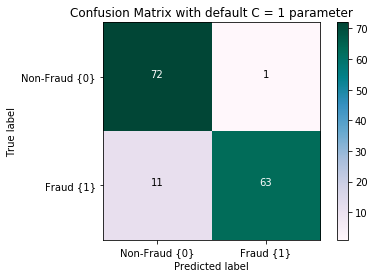

Matrix Recall: 85.13513513513513 %
Matrix Precision: 98.4375 %


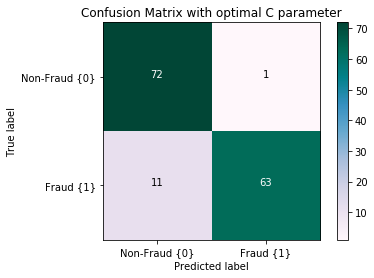

Matrix Recall: 85.13513513513513 %
Matrix Precision: 98.4375 %


In [32]:
# Use SVC optimal parameters to SVC and fit
classifier_with_best_parameters =  SVC(C= best_parameters["C"], kernel= best_parameters["kernel"], random_state= 0)
classifier_with_best_parameters.fit(training_data, training_labels.values.ravel())

# predict the new labels
y_pred_best_parameters = classifier_with_best_parameters.predict(test_data)

# create confusion matrix via optimal parameters
cm2 = confusion_matrix(test_labels, y_pred_best_parameters)

# matrix 1 with default param C = 1
plot_confusion_matrix(cm1, title = "Confusion Matrix with default C = 1 parameter")
plt.show()

# matrix 2 with optimal param
plot_confusion_matrix(cm2, title = "Confusion Matrix with optimal C parameter")
plt.show()

## Comparing the three sub-set Approaches with testing on the full Data Set

In [34]:
from sklearn.cross_validation import train_test_split

## train_test_split(data,labels,test_size %,random_state)
## combines next(ShuffleSplit().split(X, y))
## Scrambles the data and splits randomly into desired input sizes
## random_state if different values produce different resulting sets
## if random_state is set to a constant value then reproduces same results

#Data
X = df.loc[:, df.columns != 'Class']

#Labels
Y = df.loc[:, df.columns == 'Class']

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.15, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  242085
Number transactions test dataset:  42722
Total number of transactions:  284807


**Singular Vector Machine Matrix** 

In [35]:
# predicting y_pred_full_dataset
y_pred_full_dataset= classifier_with_best_parameters.predict(X_test)

# confusion matrix usign y_test_full and ypred_full
cm3 = confusion_matrix(y_test, y_pred_full_dataset)

**Logistic Regression Matrix**

In [43]:
# logistic regression
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(training_data,training_labels.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cn_lr = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

**k-NN with optimal parameter k focusing on accuracy**

In [44]:
from sklearn.neighbors import KNeighborsClassifier
import operator

## KNeighborsClassifier(n_neighbors)
# Creates a classifier with parameters n_neighbors = k

## cross_val_score(estimator,X,y,cv,scoring)
# estimator -> classifier
# X = data | Y = labels | cv = folds | scoring = type of metric to estimate
# returns a set of scoring metrics unless specified via 'scoring param'

# search for an optimal value of K for KNN

# Retrieve Y values in 1D form
Yf = np.array(Yu).T[0]

# list of reasonable k-integers to test
k_range = range(1, 40)

# list of scores from k_range
k_scores = []

#loop through reasonable values of k
for k in k_range:
    #  run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, Xu, Yf, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

index, value = max(enumerate(k_scores), key=operator.itemgetter(1))

print(B+"Optimal value of k =", index+1)
print("Has accuracy score of:", value*100, "%"+E)

Optimal value of k = 2
Has accuracy score of: 93.89795918367348 %


In [45]:
# knn full dataset confusion matrix
classifier= KNeighborsClassifier(n_neighbors = index+1)
classifier.fit(training_data, training_labels.values.ravel())

y_predknn = classifier.predict(X_test)
cm_knn = confusion_matrix(y_test,y_predknn)

SVM Classifier


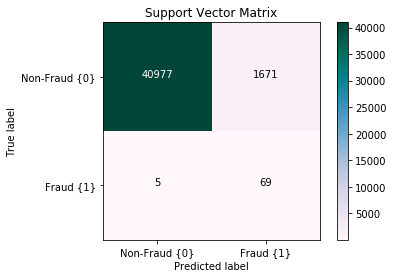

Matrix Recall: 93.24324324324324 %
Matrix Precision: 3.9655172413793105 %


In [46]:
print("SVM Classifier")
plot_confusion_matrix(cm3, "Support Vector Matrix")

Logistic Regression Classifier


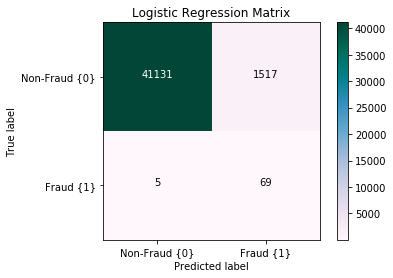

Matrix Recall: 93.24324324324324 %
Matrix Precision: 4.350567465321563 %


In [47]:
print("Logistic Regression Classifier")
plot_confusion_matrix(cn_lr, "Logistic Regression Matrix")

kNN Classifier


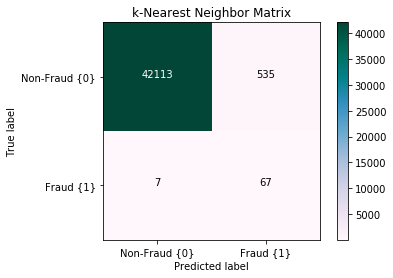

Matrix Recall: 90.54054054054053 %
Matrix Precision: 11.129568106312291 %


In [48]:
print("kNN Classifier")
plot_confusion_matrix(cm_knn, title = "k-Nearest Neighbor Matrix")

*In conclusion:*

1. The models were all very high in recall
    - The recalls varied slightly and were different for each different scrambled sub-set.
2. It was noticeable that k-NN had consistently highest precision, meaning it was the best model for fraud detection along with least false alarms.
    - This was is due to the focus on the accuracy metric vs. recall metric when finding the optimal k value.
    - Accuracy is a balance between recall and precision.
3. Given already an almost capped recall, an increase of precision would drastically help reduce the number of false frauds detected.